# Piecewise Interrupted Time Series (Segmented Regression)

This notebook demonstrates the `PiecewiseITS` experiment class, which implements segmented regression / piecewise linear models for Interrupted Time Series analysis with **known** interruption dates.

## Key Differences from Standard ITS

Unlike the standard {class}`~causalpy.InterruptedTimeSeries` which:
- Fits a model to **pre-intervention** data only
- Forecasts a counterfactual for the post-intervention period

`PiecewiseITS`:
- Fits **one model to the full time series**
- Estimates explicit **level** and/or **slope** changes at each interruption
- Computes the counterfactual by "turning off" interruption terms

This approach:
- Naturally supports **one or multiple** interruption dates
- Provides interpretable parameters per interruption
- Is widely used in applied fields (epidemiology, policy evaluation)


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import causalpy as cp
from causalpy.data.simulate_data import generate_piecewise_its_data

%config InlineBackend.figure_format = 'retina'

## Example 1: Single Intervention with Level + Slope Change

The most common piecewise ITS scenario involves a single intervention that causes both:
- An immediate **level shift** (step change)
- A change in the **slope** (trend change)

The model is:

$$y_t = \beta_0 + \beta_1 t + \beta_2 I(t) + \beta_3 R(t) + \epsilon_t$$

Where:
- $\beta_0$: baseline intercept
- $\beta_1$: baseline slope
- $\beta_2$: level change at interruption (step function $I(t) = 1[t \geq T_0]$)
- $\beta_3$: slope change at interruption (ramp function $R(t) = \max(0, t - T_0)$)


In [2]:
# Generate synthetic data with known parameters
df1, params1 = generate_piecewise_its_data(
    N=100,
    interruption_times=[50],
    baseline_intercept=10.0,
    baseline_slope=0.1,
    level_changes=[5.0],  # Immediate level shift of 5 units
    slope_changes=[0.15],  # Slope increases by 0.15 per time unit
    noise_sigma=1.0,
    seed=42,
)

print("True parameters:")
print(f"  Baseline intercept: {params1['baseline_intercept']}")
print(f"  Baseline slope: {params1['baseline_slope']}")
print(f"  Level change: {params1['level_changes'][0]}")
print(f"  Slope change: {params1['slope_changes'][0]}")

df1.head()

True parameters:
  Baseline intercept: 10.0
  Baseline slope: 0.1
  Level change: 5.0
  Slope change: 0.15


,t,y,y_true,counterfactual,effect
0,0,10.496714,10.0,10.0,0.0
1,1,9.961736,10.1,10.1,0.0
2,2,10.847689,10.2,10.2,0.0
3,3,11.823030,10.3,10.3,0.0
4,4,10.165847,10.4,10.4,0.0


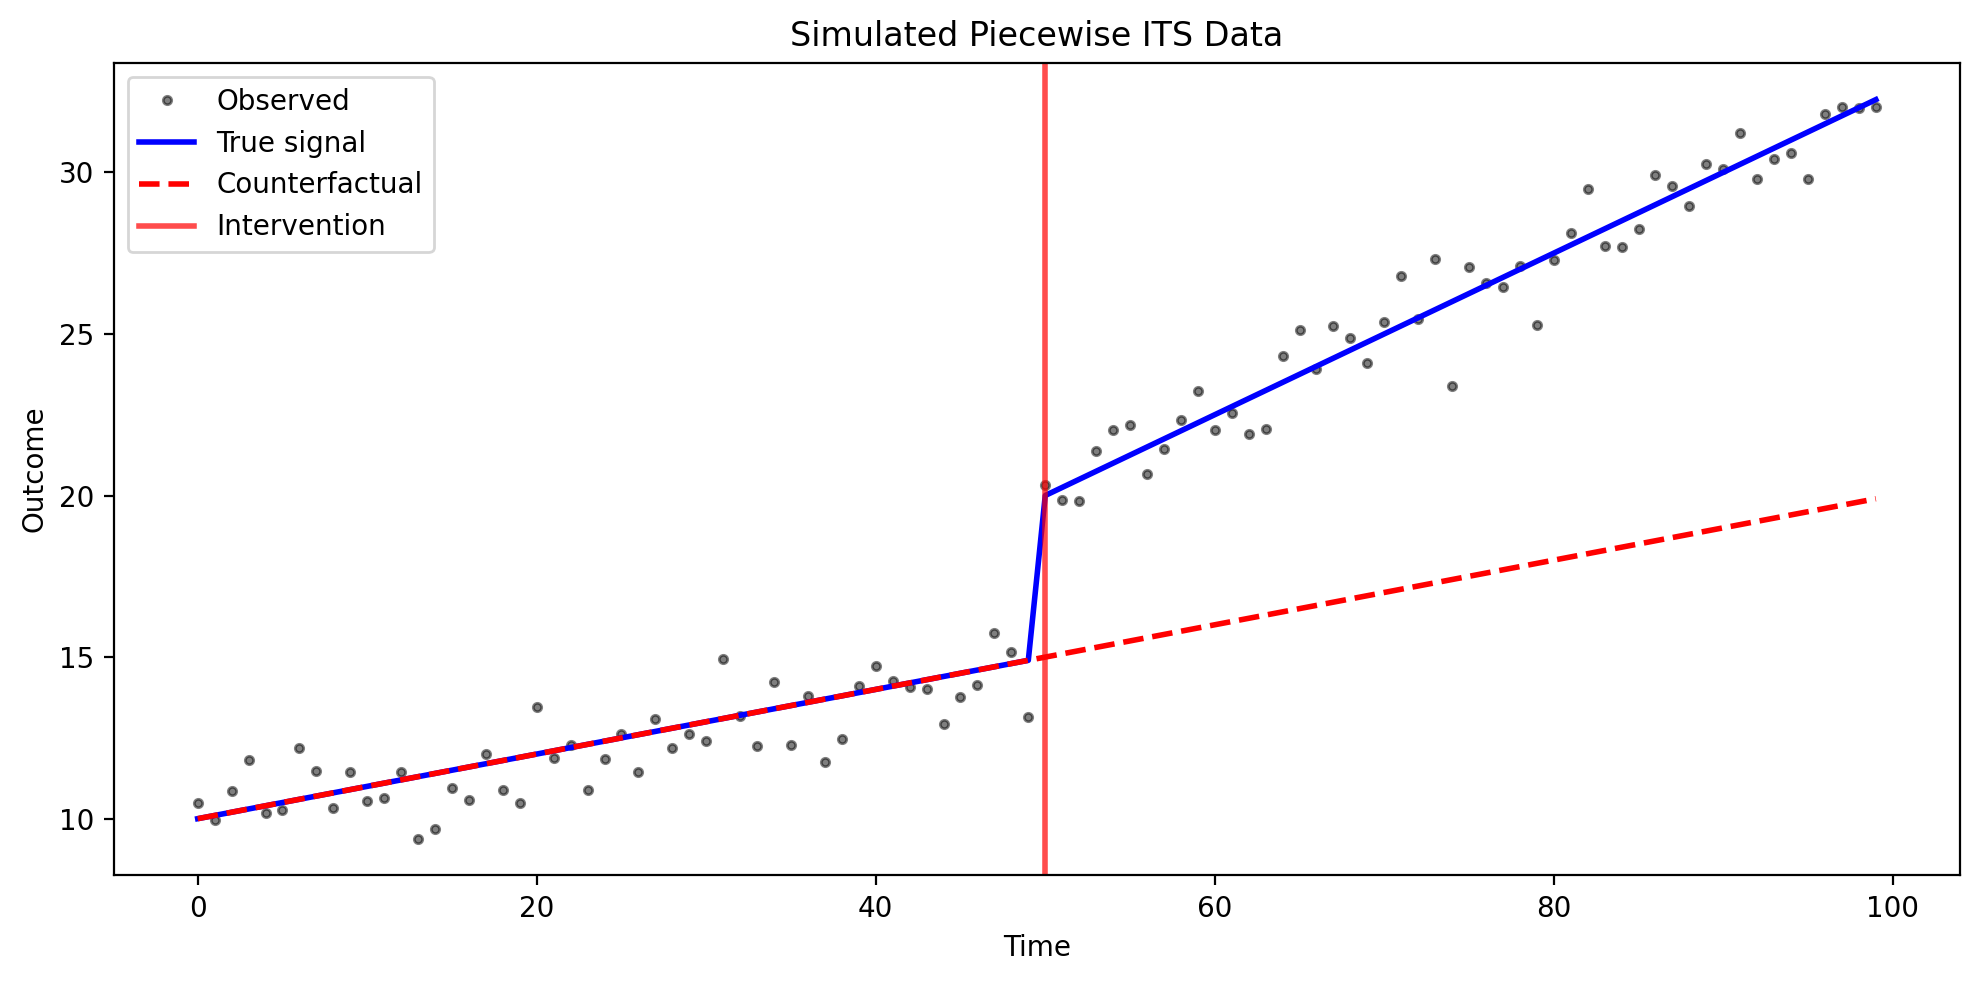

In [3]:
# Visualize the raw data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df1["t"], df1["y"], "k.", alpha=0.5, label="Observed")
ax.plot(df1["t"], df1["y_true"], "b-", lw=2, label="True signal")
ax.plot(df1["t"], df1["counterfactual"], "r--", lw=2, label="Counterfactual")
ax.axvline(x=50, color="red", ls="-", lw=2, alpha=0.7, label="Intervention")
ax.set_xlabel("Time")
ax.set_ylabel("Outcome")
ax.set_title("Simulated Piecewise ITS Data")
ax.legend()
plt.tight_layout()

In [4]:
# Fit the PiecewiseITS model with PyMC
result1 = cp.PiecewiseITS(
    df1,
    outcome="y",
    time="t",
    interruption_times=[50],
    include_level_change=True,
    include_slope_change=True,
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [5]:
# Display model summary
result1.summary()

=======================Piecewise Interrupted Time Series========================
Outcome: y
Time column: t
Interruption times: [50]
Level change: True
Slope change: True
Model coefficients:
    Intercept    10, 94% HDI [9.6, 11]
    time         0.088, 94% HDI [0.072, 0.1]
    level_0      5.7, 94% HDI [5, 6.4]
    slope_0      0.16, 94% HDI [0.13, 0.18]
    y_hat_sigma  0.91, 94% HDI [0.8, 1]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:554: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


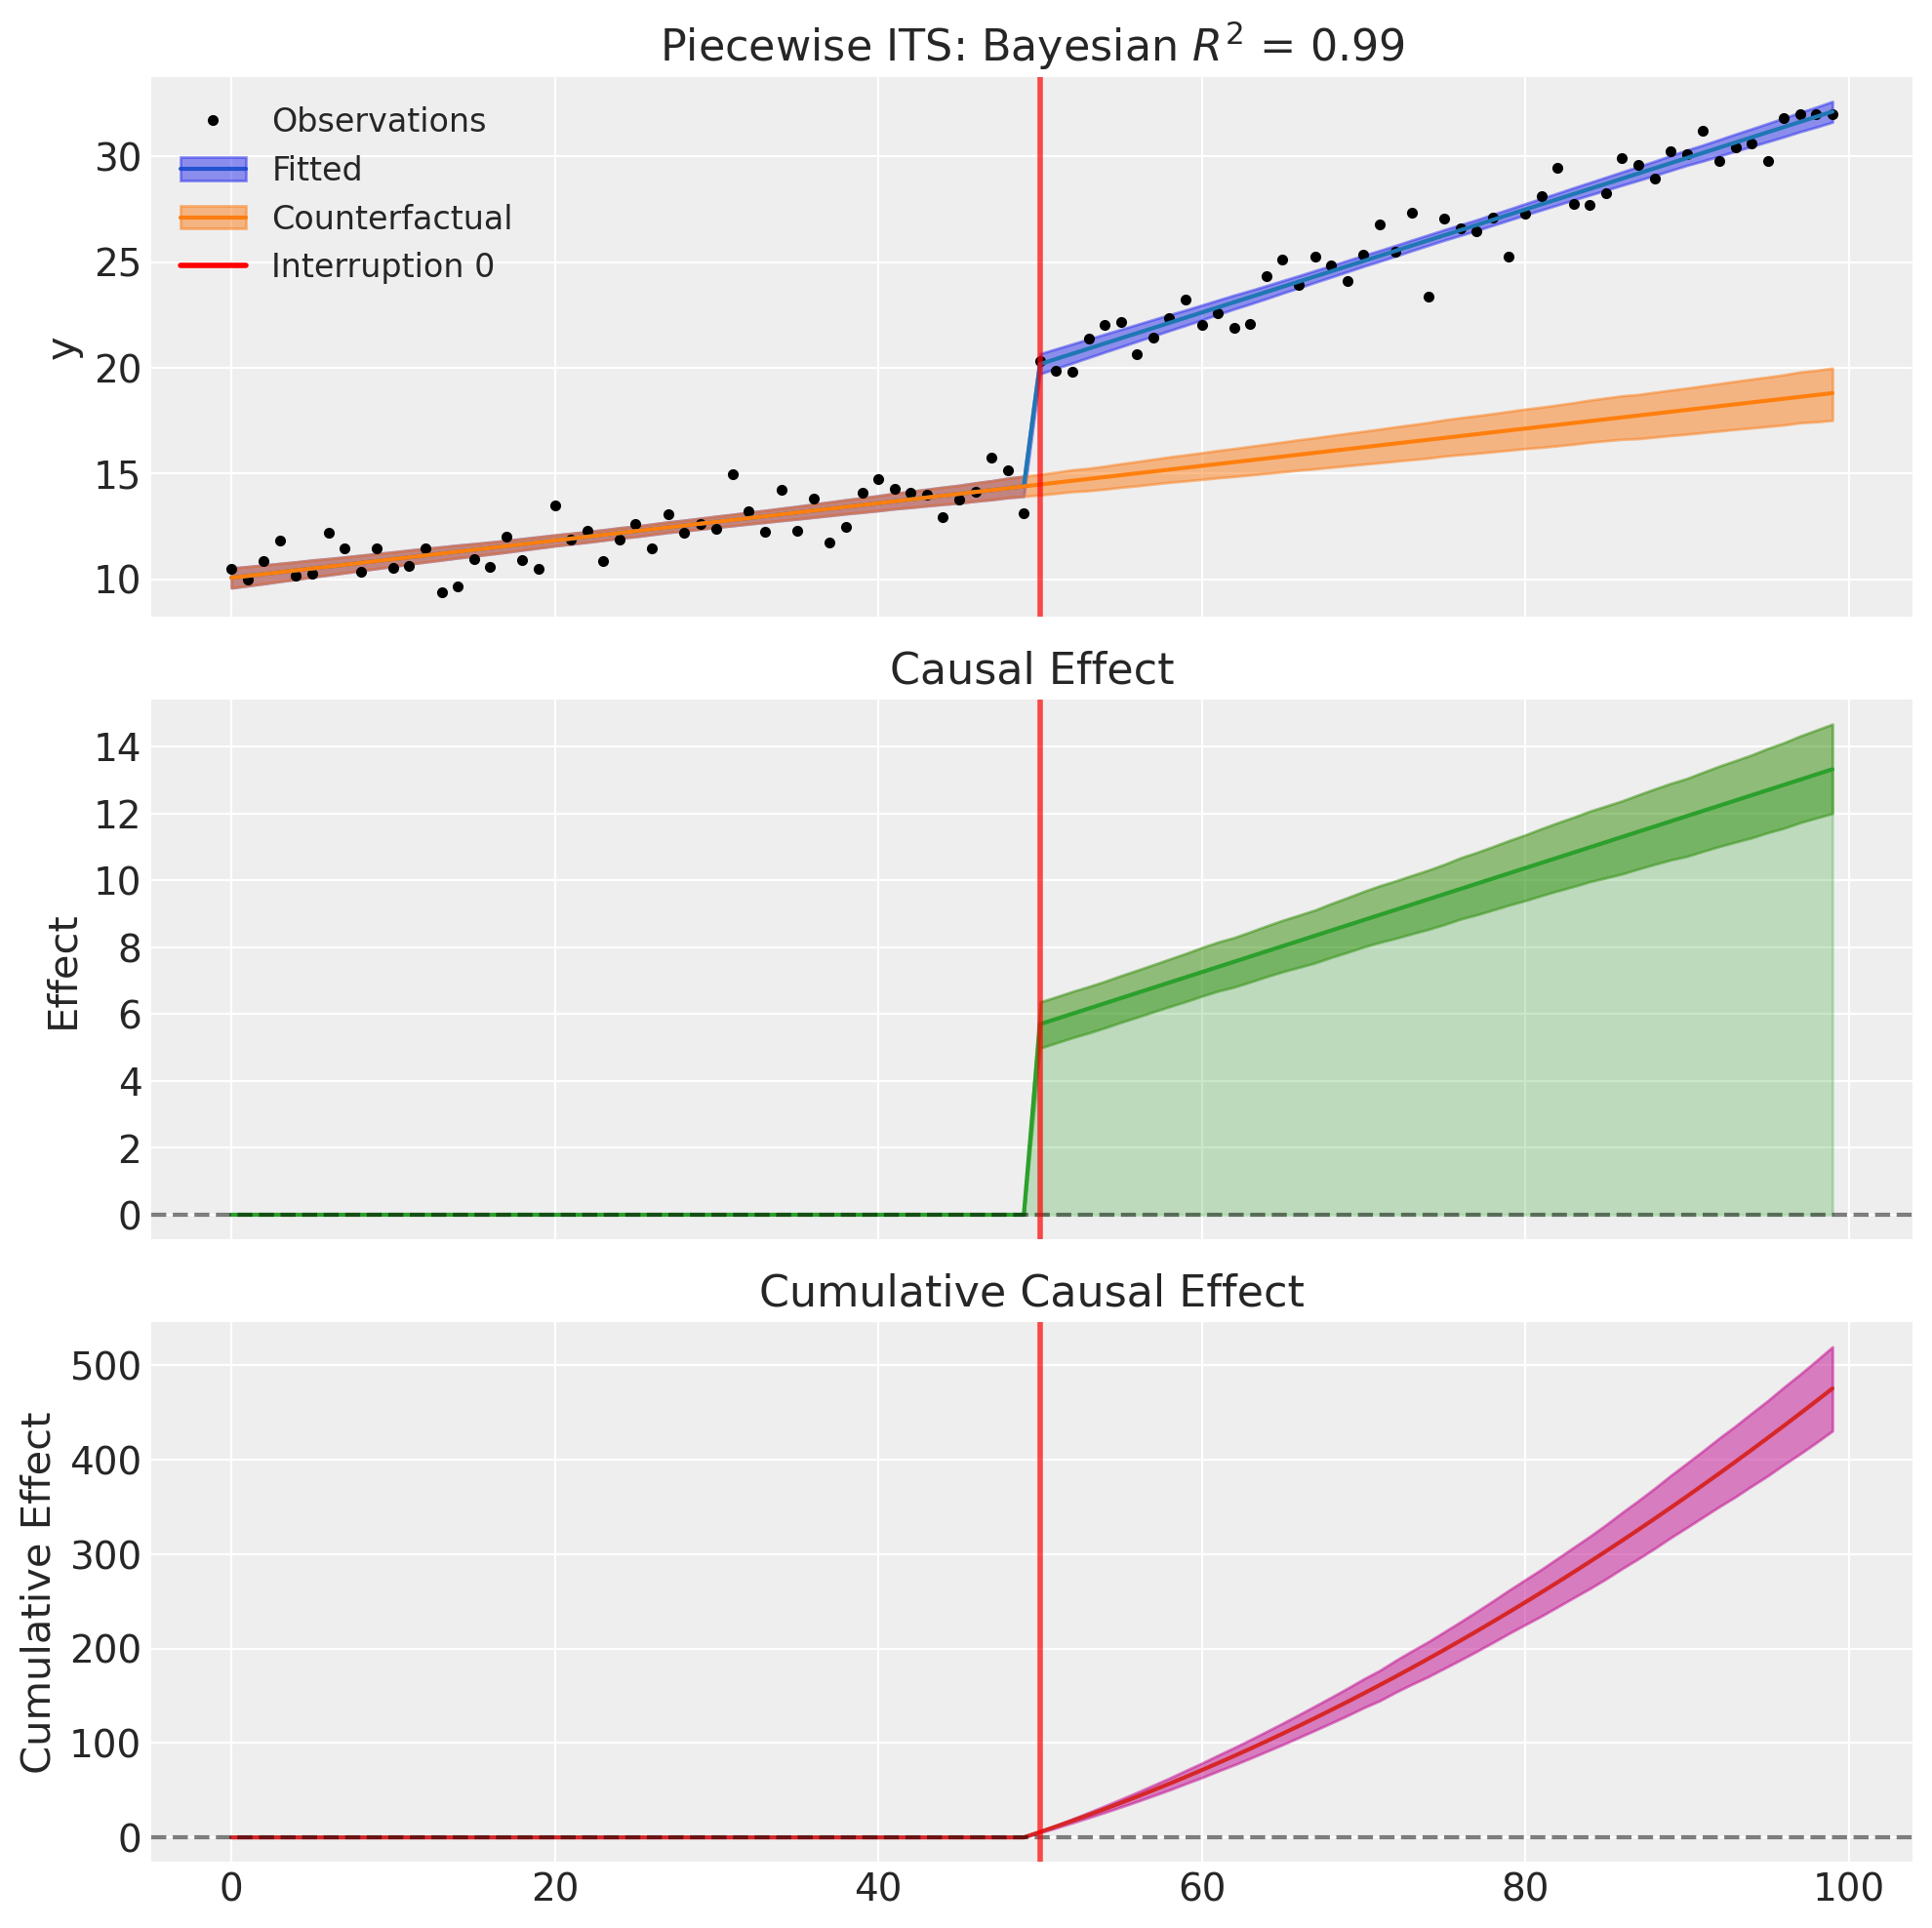

In [6]:
# Plot the results
fig, ax = result1.plot()

## Example 2: Multiple Interventions (2 Interruptions)

Real-world scenarios often involve multiple interventions over time. `PiecewiseITS` handles this naturally by adding step and ramp terms for each interruption.

The model becomes:

$$y_t = \beta_0 + \beta_1 t + \sum_{k=1}^{K} (\beta_{2k} I_k(t) + \beta_{3k} R_k(t)) + \epsilon_t$$


In [7]:
# Generate data with two interruptions
df2, params2 = generate_piecewise_its_data(
    N=150,
    interruption_times=[50, 100],
    baseline_intercept=10.0,
    baseline_slope=0.08,
    level_changes=[4.0, -3.0],  # First intervention increases, second decreases
    slope_changes=[0.1, -0.12],  # First steepens, second flattens
    noise_sigma=1.0,
    seed=42,
)

print("True parameters:")
print(f"  Baseline intercept: {params2['baseline_intercept']}")
print(f"  Baseline slope: {params2['baseline_slope']}")
print(f"  Level changes: {params2['level_changes']}")
print(f"  Slope changes: {params2['slope_changes']}")

True parameters:
  Baseline intercept: 10.0
  Baseline slope: 0.08
  Level changes: [4.0, -3.0]
  Slope changes: [0.1, -0.12]


In [8]:
# Fit the model
result2 = cp.PiecewiseITS(
    df2,
    outcome="y",
    time="t",
    interruption_times=[50, 100],
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [9]:
result2.summary()

=======================Piecewise Interrupted Time Series========================
Outcome: y
Time column: t
Interruption times: [50, 100]
Level change: True
Slope change: True
Model coefficients:
    Intercept    10, 94% HDI [9.6, 11]
    time         0.068, 94% HDI [0.051, 0.085]
    level_0      4.7, 94% HDI [4, 5.4]
    slope_0      0.11, 94% HDI [0.081, 0.13]
    level_1      -2.8, 94% HDI [-3.6, -2.1]
    slope_1      -0.12, 94% HDI [-0.14, -0.091]
    y_hat_sigma  0.95, 94% HDI [0.85, 1.1]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:554: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


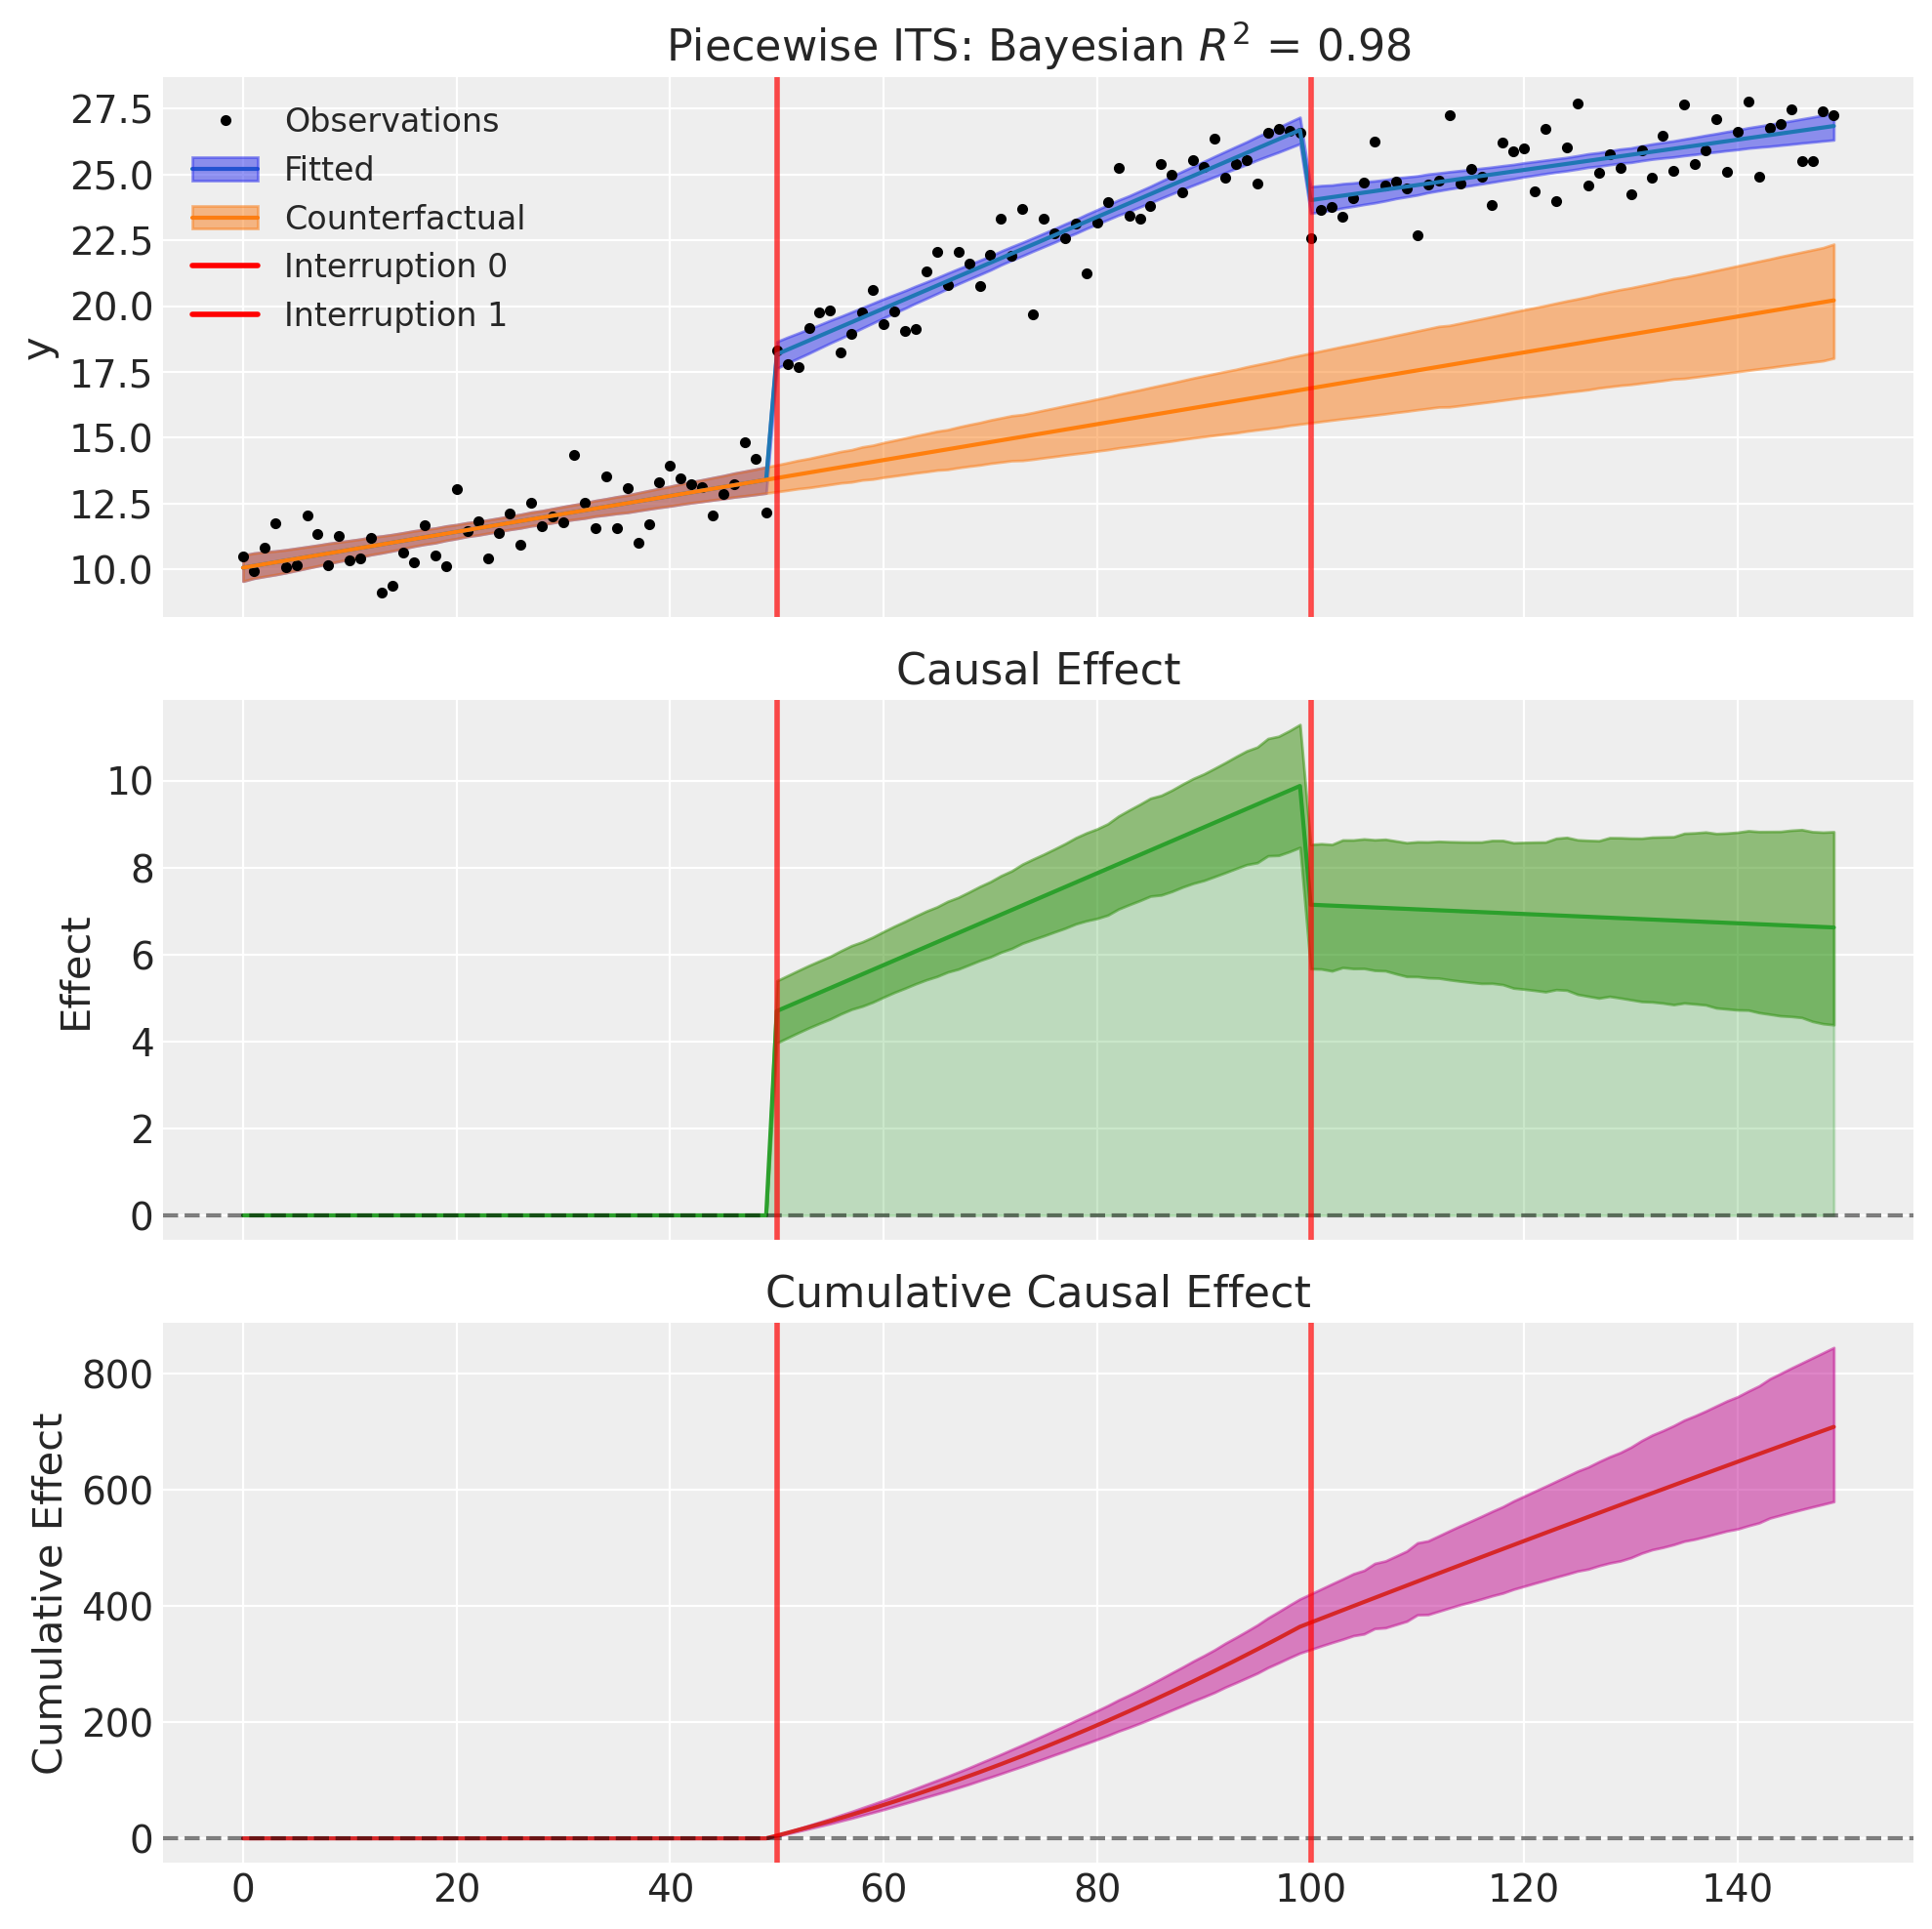

In [10]:
fig, ax = result2.plot()

## Example 3: Level Change Only (Baseline Shift)

Some interventions cause an immediate level shift but don't change the underlying trend. This is common for:
- Policy interventions with immediate effect
- Price changes
- One-time events

We can model this by setting `include_slope_change=False`.


In [11]:
# Generate data with level change only
df3, params3 = generate_piecewise_its_data(
    N=100,
    interruption_times=[50],
    baseline_intercept=20.0,
    baseline_slope=0.05,
    level_changes=[8.0],  # Large immediate shift
    slope_changes=[0.0],  # No slope change
    noise_sigma=1.5,
    seed=42,
)

print("True parameters:")
print(
    f"  Level change: {params3['level_changes'][0]} (slope change: {params3['slope_changes'][0]})"
)

True parameters:
  Level change: 8.0 (slope change: 0.0)


In [12]:
# Fit with level change only
result3 = cp.PiecewiseITS(
    df3,
    outcome="y",
    time="t",
    interruption_times=[50],
    include_level_change=True,
    include_slope_change=False,  # Only estimate level change
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [13]:
result3.summary()

=======================Piecewise Interrupted Time Series========================
Outcome: y
Time column: t
Interruption times: [50]
Level change: True
Slope change: False
Model coefficients:
    Intercept    20, 94% HDI [19, 21]
    time         0.036, 94% HDI [0.019, 0.053]
    level_0      9, 94% HDI [8.1, 10]
    y_hat_sigma  1.4, 94% HDI [1.2, 1.5]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:554: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


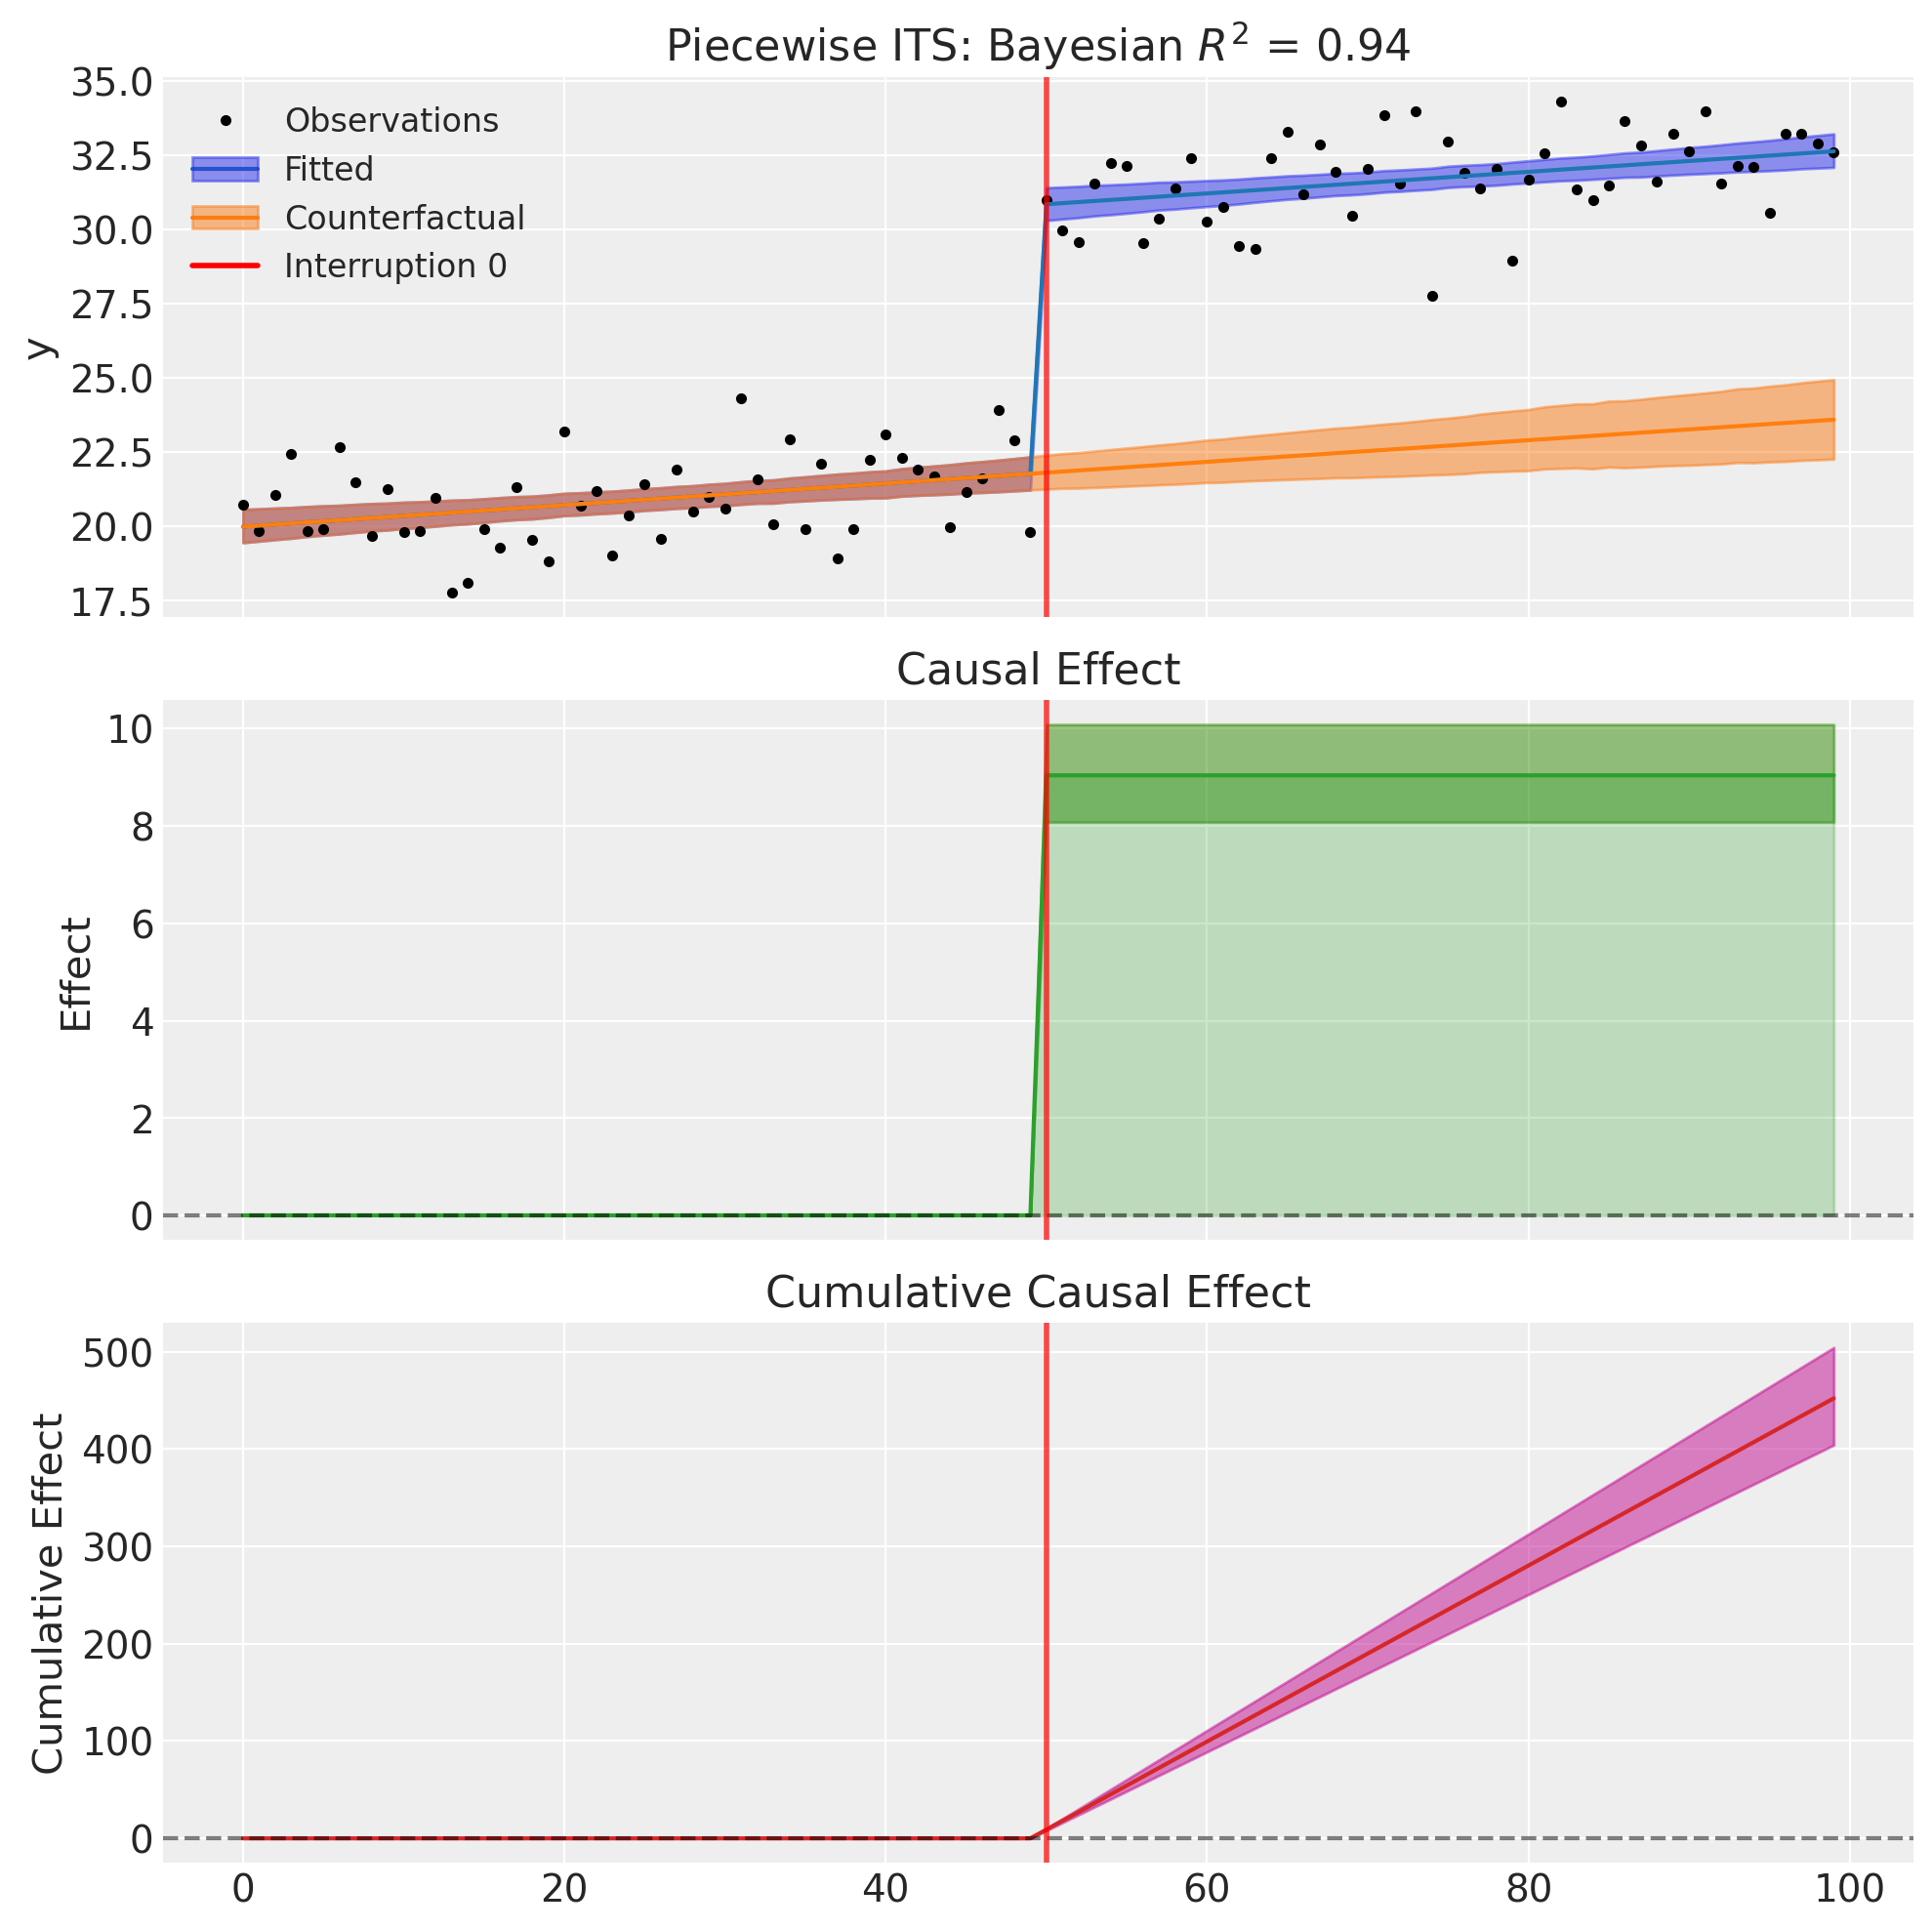

In [14]:
fig, ax = result3.plot()

## Example 4: Slope Change Only (Trend Break)

Some interventions change the trajectory without an immediate effect. This is common for:
- Gradual interventions
- Educational programs
- Long-term policy changes

We can model this by setting `include_level_change=False`.


In [15]:
# Generate data with slope change only
df4, params4 = generate_piecewise_its_data(
    N=100,
    interruption_times=[50],
    baseline_intercept=15.0,
    baseline_slope=0.05,
    level_changes=[0.0],  # No immediate shift
    slope_changes=[0.2],  # Significant slope change
    noise_sigma=1.0,
    seed=42,
)

print("True parameters:")
print(
    f"  Level change: {params4['level_changes'][0]} (slope change: {params4['slope_changes'][0]})"
)

True parameters:
  Level change: 0.0 (slope change: 0.2)


In [16]:
# Fit with slope change only
result4 = cp.PiecewiseITS(
    df4,
    outcome="y",
    time="t",
    interruption_times=[50],
    include_level_change=False,  # Only estimate slope change
    include_slope_change=True,
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "draws": 2000,
            "tune": 1000,
            "chains": 4,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [17]:
result4.summary()

=======================Piecewise Interrupted Time Series========================
Outcome: y
Time column: t
Interruption times: [50]
Level change: False
Slope change: True
Model coefficients:
    Intercept    15, 94% HDI [14, 15]
    time         0.049, 94% HDI [0.035, 0.062]
    slope_0      0.2, 94% HDI [0.18, 0.23]
    y_hat_sigma  0.92, 94% HDI [0.8, 1.1]


/Users/benjamv/git/CausalPy/causalpy/experiments/piecewise_its.py:554: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


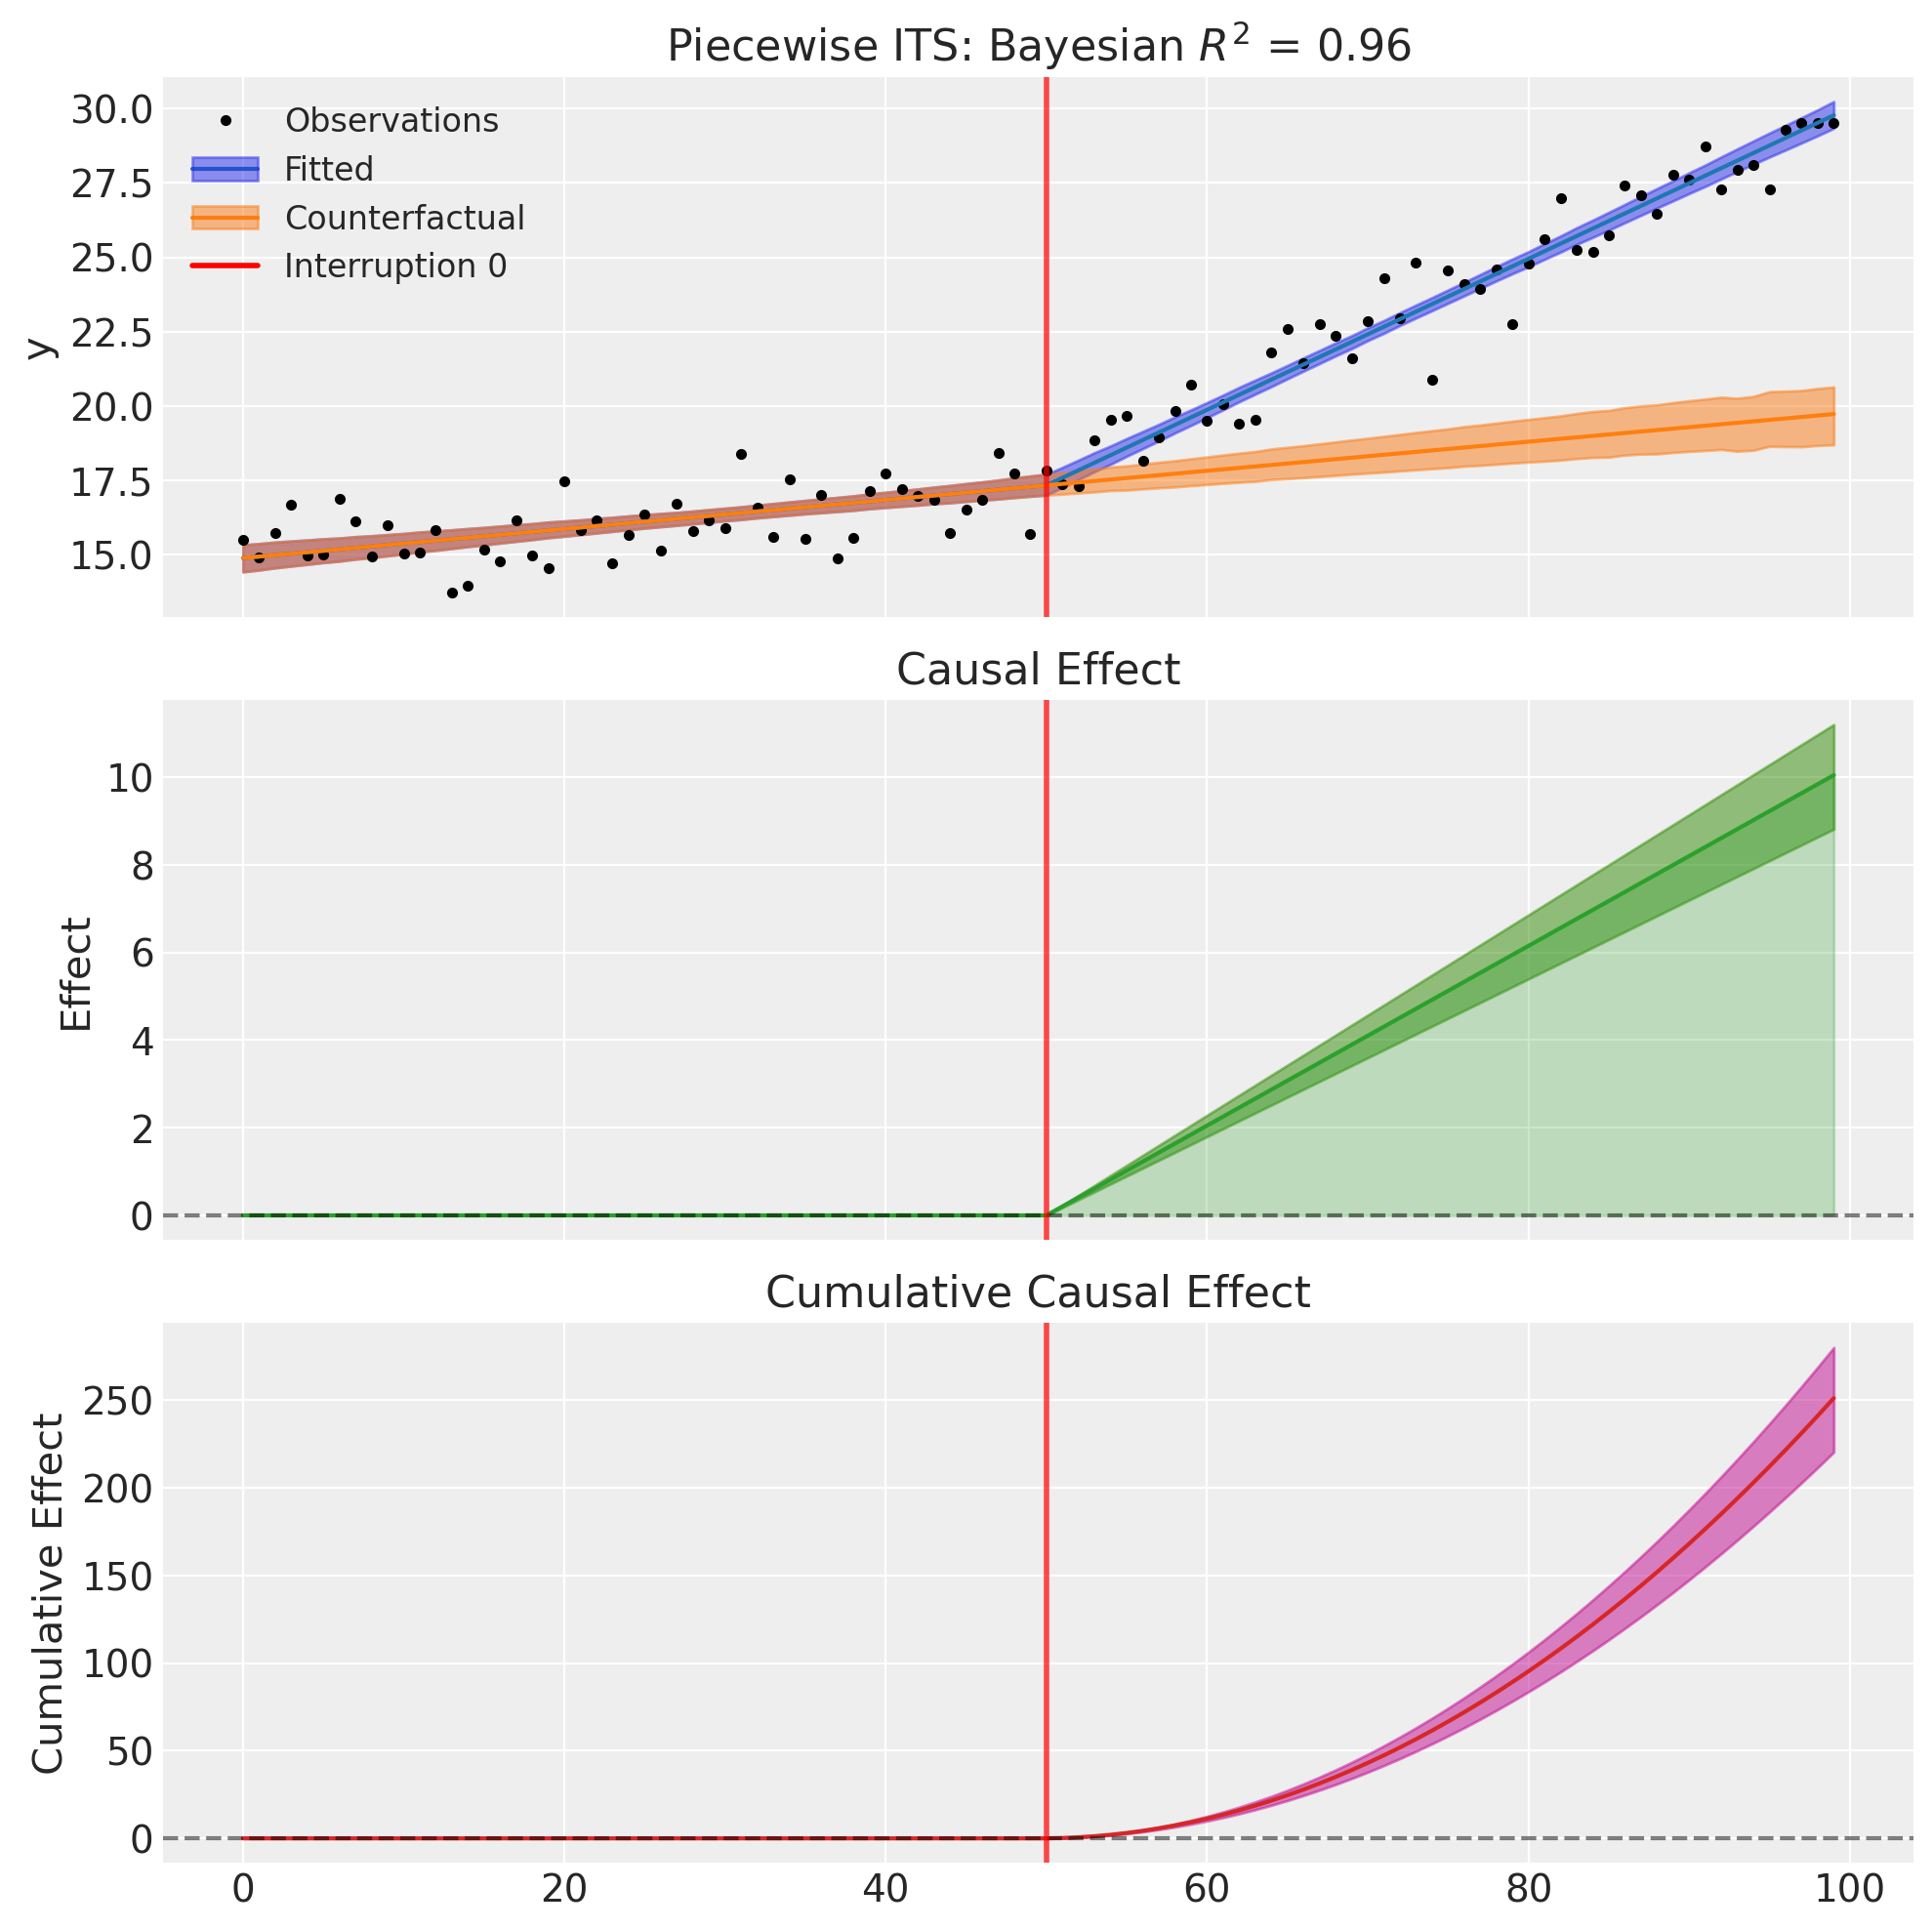

In [18]:
fig, ax = result4.plot()

Notice that the causal effect starts at zero at the intervention time and grows linearly as the slope change accumulates over time.


## Accessing Plot Data

You can extract the underlying data for custom visualizations:


In [19]:
plot_data = result1.get_plot_data()
plot_data.head(10)

,t,y,fitted,fitted_hdi_lower_94,fitted_hdi_upper_94,counterfactual,counterfactual_hdi_lower_94,counterfactual_hdi_upper_94,effect,effect_hdi_lower_94,effect_hdi_upper_94,cumulative_effect,cumulative_effect_hdi_lower_94,cumulative_effect_hdi_upper_94
0,0,10.496714,10.062961,9.586708,10.522773,10.062961,9.586708,10.522773,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9.961736,10.151201,9.684482,10.591531,10.151201,9.684482,10.591531,0.0,0.0,0.0,0.0,0.0,0.0
2,2,10.847689,10.239441,9.784644,10.664292,10.239441,9.784644,10.664292,0.0,0.0,0.0,0.0,0.0,0.0
3,3,11.823030,10.327681,9.890569,10.741337,10.327681,9.890569,10.741337,0.0,0.0,0.0,0.0,0.0,0.0
4,4,10.165847,10.415921,9.991047,10.815082,10.415921,9.991047,10.815082,0.0,0.0,0.0,0.0,0.0,0.0
5,5,10.265863,10.504161,10.102156,10.900146,10.504161,10.102156,10.900146,0.0,0.0,0.0,0.0,0.0,0.0
6,6,12.179213,10.592401,10.196498,10.968548,10.592401,10.196498,10.968548,0.0,0.0,0.0,0.0,0.0,0.0
7,7,11.467435,10.680641,10.299239,11.044666,10.680641,10.299239,11.044666,0.0,0.0,0.0,0.0,0.0,0.0
8,8,10.330526,10.768881,10.403156,11.125437,10.768881,10.403156,11.125437,0.0,0.0,0.0,0.0,0.0,0.0
9,9,11.442560,10.857121,10.504258,11.205406,10.857121,10.504258,11.205406,0.0,0.0,0.0,0.0,0.0,0.0


## References

- Wagner AK, Soumerai SB, Zhang F, Ross-Degnan D. (2002). Segmented regression analysis of interrupted time series studies in medication use research. Journal of Clinical Pharmacy and Therapeutics, 27(4):299-309.
- Lopez Bernal J, Cummins S, Gasparrini A. (2017). Interrupted time series regression for the evaluation of public health interventions: a tutorial. International Journal of Epidemiology, 46(1):348-355.
- Kontopantelis E, Doran T, Springate DA, Buchan I, Reeves D. (2015). Regression based quasi-experimental approach when randomisation is not an option: interrupted time series analysis. BMJ, 350:h2750.
